# 와인 품질 데이터 분석 및 성능 최적화

**목표**: 와인의 12가지 화학적 특성을 분석하여 품질(또는 종류)을 예측하는 딥러닝 모델을 구축합니다.
특히 **Early Stopping**과 **Model Checkpoint** 콜백을 사용하여 모델의 과적합을 방지하고 최적의 성능을 확보하는 방법에 집중합니다.

**작성자**: AI Assistant
**날짜**: 2026-01-09

## 1. 환경 설정 및 데이터 로드

분석에 필요한 라이브러리를 불러오고 `wine.csv` 데이터를 로드합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# 시각화 설정
sns.set(style="whitegrid")
np.random.seed(42)

/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# 데이터 로드
df = pd.read_csv('../../data/wine.csv', header=None)
print(f"데이터 크기: {df.shape}")

# 컬럼 이름을 문자열로 변환 (Seaborn 등 시각화 라이브러리 호환성 해결)
df.columns = df.columns.astype(str)

# 12개 Feature + 1개 Target (총 13개 컬럼으로 보임)
df.head()

데이터 크기: (6497, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


## 2. 데이터 탐색 (EDA)
데이터의 구조와 타겟 변수의 분포를 확인합니다.

In [3]:
# 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6497 non-null   float64
 1   1       6497 non-null   float64
 2   2       6497 non-null   float64
 3   3       6497 non-null   float64
 4   4       6497 non-null   float64
 5   5       6497 non-null   float64
 6   6       6497 non-null   float64
 7   7       6497 non-null   float64
 8   8       6497 non-null   float64
 9   9       6497 non-null   float64
 10  10      6497 non-null   float64
 11  11      6497 non-null   int64  
 12  12      6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


타겟 클래스 분포:
12
0    4898
1    1599
Name: count, dtype: int64


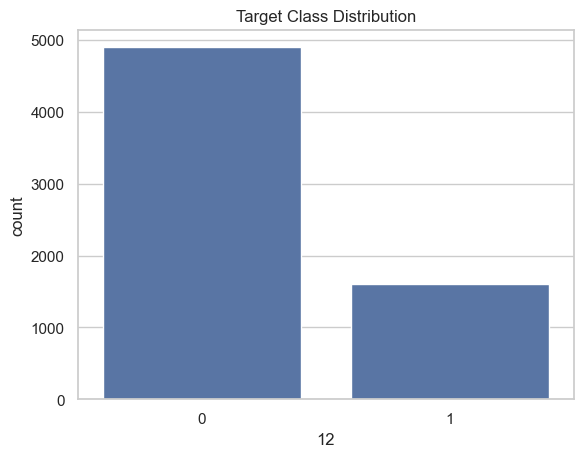

In [4]:
# 타겟 변수 (마지막 컬럼) 확인
target_col = df.columns[-1]
print("타겟 클래스 분포:")
print(df[target_col].value_counts())

sns.countplot(x=target_col, data=df)
plt.title("Target Class Distribution")
plt.show()

**해석**:
- 데이터는 수치형으로 구성되어 있으며 결측치는 없는 것으로 보입니다.
- 타겟 클래스가 1과 0으로 나뉘어 있어 **이진 분류(Binary Classification)** 문제입니다.

## 3. 데이터 전처리
- **특성과 타겟 분리(X, y)**
- **스케일링**: 딥러닝 학습 효율을 위해 `StandardScaler` 적용
- **Train/Test 분리**: 학습 성능 검증을 위해 데이터를 분리

In [5]:
X = df.iloc[:, 0:12]
y = df.iloc[:, 12]

# Train/Test 분리 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train Set Shape:", X_train_scaled.shape)
print("Test Set Shape:", X_test_scaled.shape)

Train Set Shape: (5197, 12)
Test Set Shape: (1300, 12)


## 4. 딥러닝 모델 설계 및 콜백 설정
다층 퍼셉트론(MLP) 모델을 설계하고, 학습 과정을 제어할 **Callback** 함수를 정의합니다.

### 콜백(Callback) 설명
1. **ModelCheckpoint**: 검증 손실(`val_loss`)을 모니터링하다가 개선될 때마다 모델을 파일로 저장합니다. 학습이 끝난 후 가장 좋았던 모델을 불러올 수 있습니다.
2. **EarlyStopping**: 검증 손실이 더 이상 개선되지 않으면(patience 횟수만큼), 불필요한 추가 학습을 멈추고 종료합니다.

In [6]:
# 모델 저장 경로
model_path = './model/best_wine_model.keras'

# 1. ModelCheckpoint: val_loss가 좋아질 때만 저장 (save_best_only=True)
checkpointer = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

# 2. EarlyStopping: val_loss가 20번(patience) 동안 개선되지 않으면 중단
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20, verbose=1)


def create_wine_model():
    model = Sequential()
    model.add(Dense(30, input_dim=12, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_wine_model()
model.summary()

/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-09 12:16:04.387772: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2026-01-09 12:16:04.387804: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2026-01-09 12:16:04.387812: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 25.92 GB
2026-01-09 12:16:04.387829: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-09 12:16:04.387839: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fac

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 875 (3.42 KB)

 Trainable params: 875 (3.42 KB)

 Non-trainable params: 0 (0.00 B)

## 5. 모델 학습 및 평가
학습 시 `callbacks` 인자에 위에서 정의한 기능들을 리스트로 전달합니다.
Epoch을 2000으로 아주 길게 설정하더라도, `EarlyStopping` 덕분에 적절한 시점에 멈출 것입니다.

In [7]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')

# 학습 실행
history = model.fit(X_train_scaled, y_train, 
                    epochs=2000, 
                    batch_size=500, 
                    validation_split=0.25, # 20% of Train data for validation
                    verbose=0,
                    callbacks=[early_stopping_callback, checkpointer])

2026-01-09 12:16:05.049479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from None to 0.51450, saving model to ./model/best_wine_model.keras

Epoch 1: finished saving model to ./model/best_wine_model.keras

Epoch 2: val_loss improved from 0.51450 to 0.45700, saving model to ./model/best_wine_model.keras

Epoch 2: finished saving model to ./model/best_wine_model.keras

Epoch 3: val_loss improved from 0.45700 to 0.41149, saving model to ./model/best_wine_model.keras

Epoch 3: finished saving model to ./model/best_wine_model.keras

Epoch 4: val_loss improved from 0.41149 to 0.37319, saving model to ./model/best_wine_model.keras

Epoch 4: finished saving model to ./model/best_wine_model.keras

Epoch 5: val_loss improved from 0.37319 to 0.33912, saving model to ./model/best_wine_model.keras

Epoch 5: finished saving model to ./model/best_wine_model.keras

Epoch 6: val_loss improved from 0.33912 to 0.30901, saving model to ./model/best_wine_model.keras

Epoch 6: finished saving model to ./model/best_wine_model.keras

Epoch 7: val_loss 

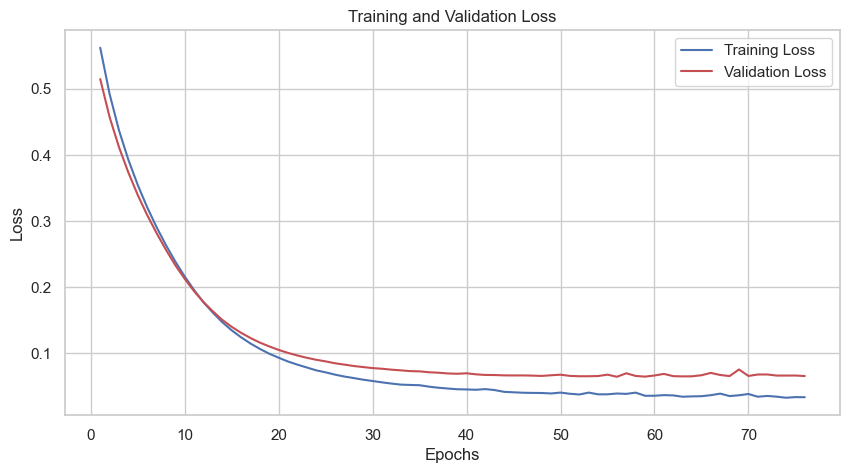

In [8]:
# 학습 결과 시각화
val_loss = history.history['val_loss']
loss = history.history['loss']
epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, loss, 'b', label='Training Loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6. 최종 성능 확인
학습이 끝난 후 현재 메모리에 있는 모델(Last Model)과 저장된 최고의 모델(Best Model)의 성능을 비교해 봅니다.
일반적으로 과적합이 시작되기 전 저장된 **Best Model**의 성능이 더 좋습니다.

In [9]:
# 1. 현재(마지막) 모델 평가
loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"마지막 모델 정확도: {acc:.4f}")

# 2. Best Model 로드 및 평가
try:
    # Keras 3.x에서는 .keras 파일을 로드합니다.
    best_model = load_model(model_path)
    best_loss, best_acc = best_model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Best 모델 정확도 : {best_acc:.4f}")
except Exception as e:
    print(f"모델 로드 중 오류 발생: {e}")

마지막 모델 정확도: 0.9954
Best 모델 정확도 : 0.9931


**결론**:
- Callback을 활용하여 검증 오차가 가장 낮은 시점의 모델을 확보했습니다.
- 이를 통해 불필요한 과적합을 방지하고 일반화 성능을 높일 수 있습니다.